In [31]:
import simpy
import random
import matplotlib.pyplot as plt
from scipy import stats 
import numpy as np
import math

tiempo={}
nMaquina=[0,0]
vehiculosPesados=['buseta','bus','camion']
repetir=[]
aprobados=[]
no_aprobados=[]
num_vehiculos_por_dia=[]
carril1=[]
carril2=[]
carril3=[]
tiempos_acum=[]

total_no_aprobados=[]
total_aprobados=[]

carriles={'carril1':[],'carril2':[],'carril3':[]}

ac=0


class EMOV(object):
    
    def __init__(self, environment, num_carril_normal, num_carril_grande):
        self.env=environment
        self.carril_normal = simpy.Resource(environment, num_carril_normal)
        self.carril_grande = simpy.Resource(environment, num_carril_grande)

    def revisión(self, vehiculo):

        global ac

        tiempoAleatorio=0
        while True:
            mu, sigma = 20/60, 10/60 # media y desvio estandar
            normal = stats.norm(mu, sigma)
            tiempoAleatorio = normal.rvs(1) # genera aleatorios

            # print('El vehiculo: ',vehiculo,)
            if tiempoAleatorio>=0:
                break
        
        ac+=tiempoAleatorio

        yield self.env.timeout(tiempoAleatorio)
        

        
    
def llegada_vehiculo(env, nombre, emov):

    global nMaquina
    global repetir
    global aprobados
    global no_aprobados
    global carril1
    global carril2
    global carril3
    global total_no_aprobados
    global total_aprobados
    global ac

    # print('Llega vehiculo: %s a la hora %.2f.' % (nombre, env.now))
    
    vehi=nombre.split(' ')[0]

    t=random.randrange(3,5)

    ac+=t

    yield env.timeout(t)

    # print('El vehiculo ',nombre,' se estaciono hasta la hora',env.now)

    t=random.randrange(1,3)
    ac+=t

    yield env.timeout(t)

    # print('El vehiculo ',nombre,' saco el turno a la hora',env.now)

    t=random.randrange(5,10)
    ac+=t

    yield env.timeout(t)

    # print('El vehiculo ',nombre,' termino de pagar la matricula a la hora',env.now)

    if vehi not in vehiculosPesados:

        with emov.carril_normal.request() as carril_norm:

            yield carril_norm
            nM=0
            for i in range(len(nMaquina)):
                if nMaquina[i] == 0:
                    nM=i+1
                    nMaquina[i] = str(carril_norm)
                    break

            vehiculo=nombre.split(' ')[0]

            if nM == 1:
                carril1.append(1)
            else:
                carril2.append(1)
            
            # print('El vehiculo ',nombre,' entra a la revision en el carril:',nM,' a la hora',env.now)

            yield env.process(emov.revisión(nombre))
            nMaquina[nM-1]=0
            # print('Vehiculo [%s] revisado a las %.2f.' % (nombre, env.now))

            pasa_no_pasa = [0,1] 
            pasa_no_pasa=np.random.choice(pasa_no_pasa, p=(0.40,0.60))

            if pasa_no_pasa == 1:
                aprobados.append(1)
                t=random.randrange(1,3)
                yield env.timeout(t)
                # print('Vehiculo [%s] puesto el sello a las %.2f.' % (nombre, env.now))
            else:
                no_aprobados.append(1)
                repetir.append(nombre)
            
            t=random.randrange(5,10)
            ac+=t
            yield env.timeout(t)
            # print('Vehiculo [%s] sale a las %.2f.' % (nombre, env.now))
            
            # k=env.now 
            # if k in tiempo:
            #     tiempo[k]=tiempo[k]+1
            # else:
            #     tiempo[k]=1

    else:

        with emov.carril_grande.request() as carril_grande:

            yield carril_grande
            
            # print('El vehiculo ',nombre,' entra a la revision en el carril:',3,' a la hora',env.now)

            yield env.process(emov.revisión(nombre))
            # print('Vehiculo [%s] revisado a las %.2f.' % (nombre, env.now))
            carril3.append(1)
            pasa_no_pasa = [0,1] 
            pasa_no_pasa=np.random.choice(pasa_no_pasa, p=(0.40,0.60))

            if pasa_no_pasa == 1:
                total_aprobados.append(1)
                aprobados.append(1)
                t=random.randrange(1,3)
                ac+=t
                yield env.timeout(t)
                # print('Vehiculo [%s] puesto el sello a las %.2f.' % (nombre, env.now))
            else:
                total_no_aprobados.append(1)
                no_aprobados.append(1)
                repetir.append(nombre)

            t=random.randrange(5,10)
            ac+=t
            yield env.timeout(t)
            # print('Vehiculo [%s] sale a las %.2f.' % (nombre, env.now))
    


def ejecutar_simulacion(env, num_carril_normal, num_carril_grande):
    global num_vehiculos_por_dia
    global carril1
    global carril2
    global carril3
    global carriles
    global no_aprobados
    global repetir
    global ac
    global tiempos_acum
    
    emov=EMOV(env, num_carril_normal, num_carril_grande)
    v={'buseta':0,'bus':0,'camion':0,'automovil':0}
    # Ejecutamos la simulacion
    acum=0
    acum1=0
    aux=0
    while True:
        # yield env.timeout(random.randint(intervalo-3, intervalo+3))
            
        yield env.timeout(3)

        acum+=round(env.now)
        

        ro=math.trunc(round(env.now)/1440)

        if ro%2 == 0:
            for ve in repetir:
                env.process(llegada_vehiculo(env, ve, emov))
            repetir=[] 
        else:    
            # Mientras se lavan los vehiculos generamos mas vehiculos
            vehiculos = ['buseta','bus','camion','automovil'] 
            vehiculo= random.choices(vehiculos, weights=(0.15,0.15,0.15,0.85), k=1)
            v[str(vehiculo[0])]+=1
            env.process(llegada_vehiculo(env, str(str(vehiculo[0])+' '+str(v[str(vehiculo[0])])),emov))

        if ro != aux:
            carriles['carril1'].append(len(carril1))
            carriles['carril2'].append(len(carril2))
            carriles['carril3'].append(len(carril3))
            tiempos_acum.append(ac)
            acum1=len(carril1)+len(carril2)+len(carril3)
            num_vehiculos_por_dia.append(acum1)
            acum1=0
            acum=0
            carril1=[]
            carril2=[]
            carril3=[]
            aux=ro
            ac=0


        

In [32]:
NUM_CARRIL_NORMAL = 2

NUM_CARRIL_GRANDE = 1

TIEMPO_SIMULACION = 30*24*60


print('Lavanderia UPS')
# Inicializamos la semilla aleatoria
random.seed(77)

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_CARRIL_NORMAL, NUM_CARRIL_GRANDE))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

# print(tiempo)
# # Generamos una grafica en base al diccionario del tiempo
# etiqueta = list(tiempo.keys())
# valores = list(tiempo.values())
# plt.bar(range(len(tiempo)), valores, align="center", tick_label=etiqueta)
# plt.title("Tiempo/Salida Vehiculos")
# plt.xlabel("Tiempo")
# plt.ylabel("Nro. Vehiculos")
# plt.show()

Lavanderia UPS


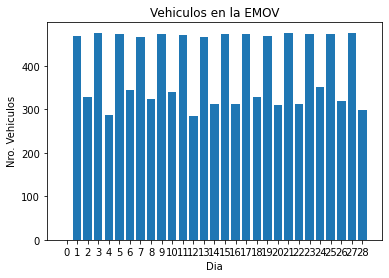

In [33]:
etiqueta = list(range(len(num_vehiculos_por_dia)))
valores = num_vehiculos_por_dia
plt.bar(etiqueta, valores, align="center", tick_label=etiqueta)
plt.title("Vehiculos en la EMOV")
plt.xlabel("Dia")
plt.ylabel("Nro. Vehiculos")
plt.show()

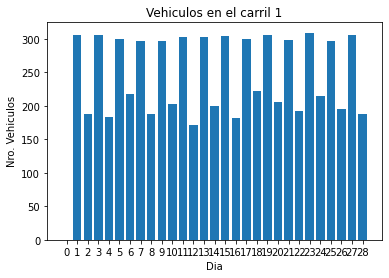

In [34]:
etiqueta = list(range(len(carriles['carril1'])))
valores = carriles['carril1']
plt.bar(etiqueta, valores, align="center", tick_label=etiqueta)
plt.title("Vehiculos en el carril 1")
plt.xlabel("Dia")
plt.ylabel("Nro. Vehiculos")
plt.show()

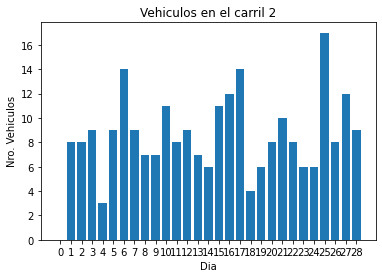

In [35]:
etiqueta = list(range(len(carriles['carril2'])))
valores = carriles['carril2']
plt.bar(etiqueta, valores, align="center", tick_label=etiqueta)
plt.title("Vehiculos en el carril 2")
plt.xlabel("Dia")
plt.ylabel("Nro. Vehiculos")
plt.show()

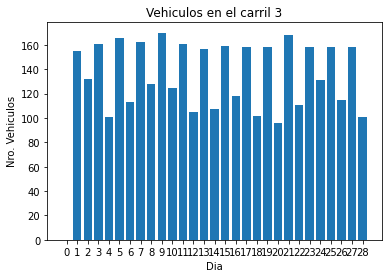

In [36]:
etiqueta = list(range(len(carriles['carril3'])))
valores = carriles['carril3']
plt.bar(etiqueta, valores, align="center", tick_label=etiqueta)
plt.title("Vehiculos en el carril 3")
plt.xlabel("Dia")
plt.ylabel("Nro. Vehiculos")
plt.show()

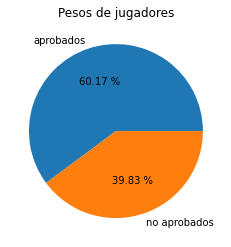

In [37]:
plt.figure()

etiquetas = ['aprobados', 'no aprobados']
plt.pie([len(total_aprobados), len(total_no_aprobados)], labels=etiquetas, autopct='%.2f %%')
plt.title('Pesos de jugadores')
plt.show()

/home/charly/.local/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/home/charly/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


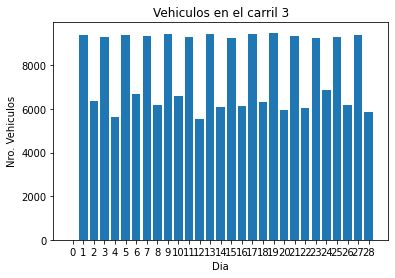

In [38]:
etiqueta = list(range(len(tiempos_acum)))
valores = tiempos_acum
plt.bar(etiqueta, valores, align="center", tick_label=etiqueta)
plt.title("Vehiculos en el carril 3")
plt.xlabel("Dia")
plt.ylabel("Nro. Vehiculos")
plt.show()